# Basic Models (Decision Tree, Bagging Regressor, Random Forest)

## One last bit of data cleaning, just removing one column that won't help here.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
df = pd.read_csv("updated.csv", low_memory=False)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [2]:
df = df.drop('Ticket', axis=1)
df = df.drop('Name', axis=1)

In [3]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,False,3,male,22.0,1,0,7.2500,S
1,True,1,female,38.0,1,0,71.2833,C
2,True,3,female,26.0,0,0,7.9250,S
3,True,1,female,35.0,1,0,53.1000,S
4,False,3,male,35.0,0,0,8.0500,S


## Double check data

### Dtypes

In [4]:
df.dtypes

Survived       bool
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

Survived boolean isn't good for models, switch to object

In [5]:
df['Survived'] = df['Survived'].astype(object)
df.dtypes

Survived     object
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [6]:
df['Sex'].value_counts()

male      577
female    312
Name: Sex, dtype: int64

In [7]:
df['Sex'] = df['Sex'].replace('male', 'M')
df['Sex'] = df['Sex'].replace('female', 'F')
df['Sex'].value_counts()

M    577
F    312
Name: Sex, dtype: int64

In [8]:
df['Sex'] = df['Sex'].astype(object)

### NaN Values

In [9]:
df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [10]:
df.shape

(889, 8)

We can afford to drop all the NaN aged people as well, not worth averaging or modeling them

In [11]:
df = df.dropna()
df.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [12]:
df.shape

(712, 8)

In [13]:
df['Survived'].value_counts()

False    424
True     288
Name: Survived, dtype: int64

In [14]:
df.to_csv(f"formodels.csv", index=False)

## Modeling

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, RocCurveDisplay, accuracy_score, precision_score, recall_score, classification_report
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

### Train Test Split

In [16]:
X = df.drop('Survived', axis=1)
y = df['Survived']
y=y.astype('int')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

### Pipelines

In [17]:
from sklearn import set_config
set_config(display='diagram')
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [18]:
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)

#### Num Pipeline

In [19]:
numeric_pipe = make_pipeline(scaler)
numeric_pipe

Pipeline(steps=[('standardscaler', StandardScaler())])

#### Obj Pipeline

In [20]:
categorical_pipe = make_pipeline(ohe)
categorical_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

#### Combine pipelines

In [21]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026886AB0100>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026886AB0220>)])

#### Fit to data

In [22]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026886AB0100>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000026886AB0220>)])

In [23]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### Function

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay

In [25]:
def evaluate(model,X_train_processed,X_test_processed,y_train,y_test):
    print(f"Training Accuracy: {model.score(X_train, y_train):.3f}")
    print(f"Test Accuracy: {model.score(X_test, y_test):.3f}")
    print(f"Train Recall: {model.score(X_test, y_test):.3f}")
    print(f"Test Recall: {model.score(X_test, y_test):.3f}")
    print(f"Dec Tree Precision: {model.score(X_test, y_test):.3f}")
    print(f"Dummy Tree Recall: {model.score(X_test, y_test):.3f}")

In [26]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('Shape test of data is', X_test_processed.shape)
print('Shape train of data is', X_train_processed.shape)
print('\n')

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


Shape test of data is (178, 10)
Shape train of data is (534, 10)




### First Model: Logreg

In [27]:
logreg = LogisticRegression(solver = 'liblinear', penalty = 'l1')
logreg_pipe = make_pipeline(scaler, logreg)
log = logreg_pipe.fit(X_train_processed, y_train)
print(logreg_pipe.score(X_train_processed, y_train))
print(logreg_pipe.score(X_test_processed, y_test))
log_pred = log.predict(X_test_processed)
log_pred = log.predict(X_test_processed)

0.8127340823970037
0.7921348314606742


#### Tuning

In [28]:
log.get_params()

{'memory': None,
 'steps': [('standardscaler', StandardScaler()),
  ('logisticregression',
   LogisticRegression(penalty='l1', solver='liblinear'))],
 'verbose': False,
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(penalty='l1', solver='liblinear'),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l1',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'liblinear',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

##### Testing all penalties

{0.0001: 0.5561797752808989,
 0.001: 0.5561797752808989,
 0.01: 0.7471910112359551,
 0.1: 0.7752808988764045,
 1: 0.7921348314606742,
 10: 0.7865168539325843,
 100: 0.7865168539325843,
 1000: 0.7865168539325843}

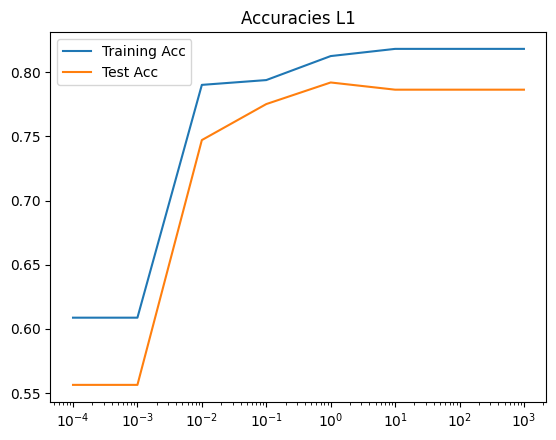

In [29]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
for c in c_values:
  logreg = LogisticRegression(C=c, solver = 'liblinear', penalty = 'l1', dual = False)
  logreg_l1_pipe = make_pipeline(scaler, logreg)
  logreg_l1_pipe.fit(X_train_processed,y_train)
  train_scores.append(logreg_l1_pipe.score(X_train_processed, y_train))
  test_scores.append(logreg_l1_pipe.score(X_test_processed, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label = 'Training Acc')
ax.plot(c_values, test_scores, label = 'Test Acc')
ax.set_xticks(c_values)
ax.set_title('Accuracies L1')
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.7640449438202247,
 0.001: 0.7584269662921348,
 0.01: 0.7528089887640449,
 0.1: 0.7808988764044944,
 1: 0.7865168539325843,
 10: 0.7865168539325843,
 100: 0.7865168539325843,
 1000: 0.7865168539325843}

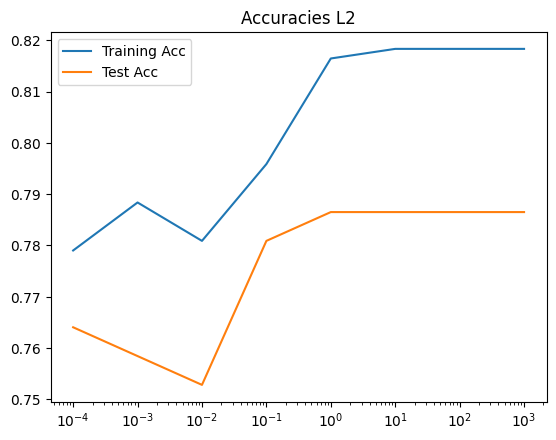

In [30]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
for c in c_values:
  logreg = LogisticRegression(C=c, solver = 'liblinear', penalty = 'l2', dual = False)
  logreg_l2_pipe = make_pipeline(scaler, logreg)
  logreg_l2_pipe.fit(X_train_processed,y_train)
  train_scores.append(logreg_l2_pipe.score(X_train_processed, y_train))
  test_scores.append(logreg_l2_pipe.score(X_test_processed, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label = 'Training Acc')
ax.plot(c_values, test_scores, label = 'Test Acc')
ax.set_xticks(c_values)
ax.set_title('Accuracies L2')
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.5561797752808989,
 0.001: 0.6404494382022472,
 0.01: 0.7584269662921348,
 0.1: 0.7865168539325843,
 1: 0.7808988764044944,
 10: 0.7865168539325843,
 100: 0.7865168539325843,
 1000: 0.7865168539325843}

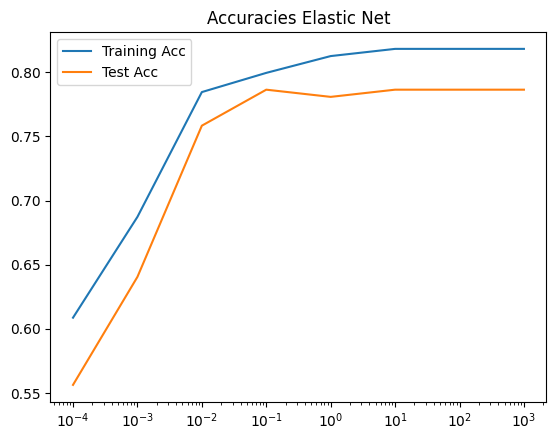

In [31]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
for c in c_values:
  logreg = LogisticRegression(C=c, solver = 'saga', penalty = 'elasticnet', l1_ratio=.001)
  logreg_elast_pipe = make_pipeline(scaler, logreg)
  logreg_elast_pipe.fit(X_train_processed,y_train)
  train_scores.append(logreg_elast_pipe.score(X_train_processed, y_train))
  test_scores.append(logreg_elast_pipe.score(X_test_processed, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label = 'Training Acc')
ax.plot(c_values, test_scores, label = 'Test Acc')
ax.set_xticks(c_values)
ax.set_title('Accuracies Elastic Net')
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_scores)}

L1 is the best, this model is decent (around 80% accurate) but not perfectbb

In [32]:
l1best = LogisticRegression(C=1, max_iter = 1000, solver = 'liblinear', penalty = 'l1', dual = False)

#### Metrics

In [33]:
l1best.fit(X_train_processed, y_train)
l1best_pred = l1best.predict(X_test_processed)
print(f"L1 Train R2: {l1best.score(X_train_processed,y_train):.3f}")
print(f"L1 Test R2: {l1best.score(X_test_processed,y_test):.3f}")
accuracy2 = accuracy_score(y_test, l1best_pred)
print(f"L1 Tree Accuracy: {accuracy2}")
recall2 = recall_score(y_test, l1best_pred, pos_label=1)
print(f"L1 Tree Recall: {recall2}")
precision2 = precision_score(y_test, l1best_pred, pos_label=1)
print(f"L1 Tree Precision: {precision2}")

L1 Train R2: 0.816
L1 Test R2: 0.792
L1 Tree Accuracy: 0.7921348314606742
L1 Tree Recall: 0.7088607594936709
L1 Tree Precision: 0.8


Training AUC: 0.8729333824070669
Testing AUC: 0.8190768443933001


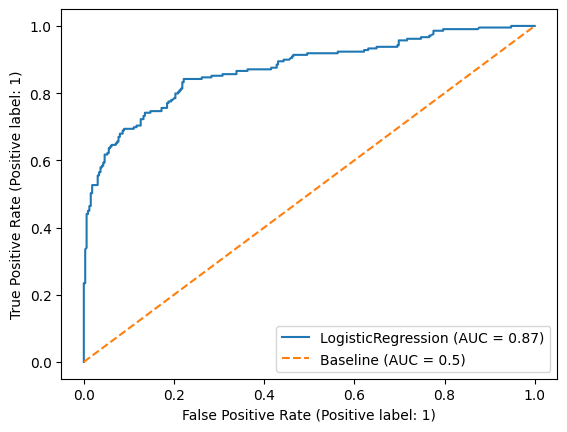

In [34]:
print(f'Training AUC: {roc_auc_score(y_train, l1best.predict_proba(X_train_processed)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, l1best.predict_proba(X_test_processed)[:,1])}')
RocCurveDisplay.from_estimator(l1best, X_train_processed, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

### KNN

In [35]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [36]:
knn = KNeighborsClassifier(n_neighbors=4)
knn_pipe = make_pipeline(scaler, knn)
knn_pipe.fit(X_train_processed, y_train)
predictions = knn_pipe.predict(X_test_processed)

#### Base model metrics

In [37]:
accuracy4 = accuracy_score(y_test, predictions)
print(f"KNN Accuracy: {accuracy4}")
recall4 = recall_score(y_test, predictions, pos_label=1)
print(f"KNN Recall: {recall4}")
precision4 = precision_score(y_test, predictions, pos_label=1)
print(f"KNN Precision: {precision4}")

KNN Accuracy: 0.7752808988764045
KNN Recall: 0.6329113924050633
KNN Precision: 0.819672131147541


#### Tuning

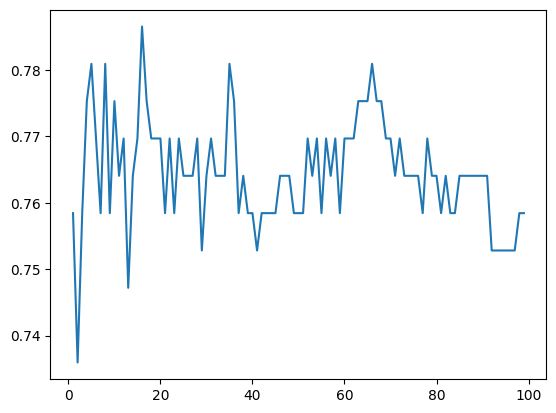

Best K value is 16 
with 0.7865168539325843 accuracy on the test set


In [38]:
krange = range(1, 100)
test_accuracies = []
bestacc = 0
bestk = 0
for k in krange:
  knn_n_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
  knn_n_pipe.fit(X_train_processed, y_train)
  acc = accuracy_score(y_test, knn_n_pipe.predict(X_test_processed))
  if acc > bestacc:
    bestacc = acc
    bestk = k

  test_accuracies.append(acc)

plt.plot(krange, test_accuracies, label='Test K Scores')
plt.show()

print(f'Best K value is {bestk} \nwith {bestacc} accuracy on the test set')

Best K Value is 16 near neighbors.

#### Finalized pipeline

In [39]:
knn_best_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 16))
knn_best_pipe.fit(X_train_processed, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=16))])

#### All metrics KNN

In [40]:
knn_best_pipe.fit(X_train_processed, y_train)
knn_best_pred = knn_pipe.predict(X_test_processed)
accuracy5 = accuracy_score(y_test, knn_best_pred)
print(f"KNN Training R2: {knn_best_pipe.score(X_train_processed,y_train):.3f}")
print(f"KNN Test R2: {knn_best_pipe.score(X_test_processed,y_test):.3f}")
print(f"KNN Accuracy: {accuracy5}")
recall5 = recall_score(y_test, knn_best_pred, pos_label=1)
print(f"KNN Recall: {recall5}")
precision5 = precision_score(y_test, knn_best_pred, pos_label=1)
print(f"KNN Precision: {precision5}")

KNN Training R2: 0.822
KNN Test R2: 0.787
KNN Accuracy: 0.7752808988764045
KNN Recall: 0.6329113924050633
KNN Precision: 0.819672131147541


Training AUC: 0.8972984909827015
Testing AUC: 0.8234241145633551


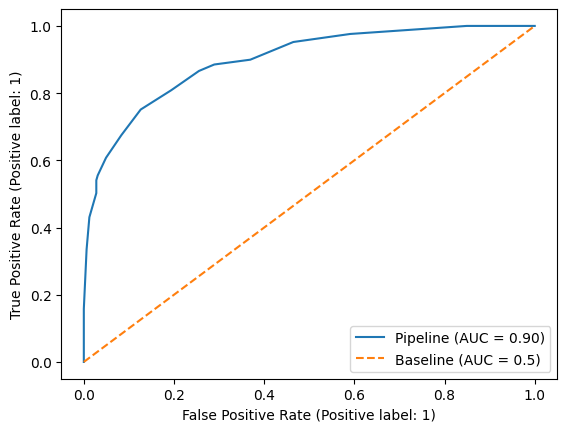

In [41]:
print(f'Training AUC: {roc_auc_score(y_train, knn_best_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, knn_best_pipe.predict_proba(X_test_processed)[:,1])}')
RocCurveDisplay.from_estimator(knn_best_pipe, X_train_processed, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

In [42]:
knn_best_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors = 16))
knn_best_pipe.fit(X_train_processed, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=16))])

In [43]:
knn_best_pipe.fit(X_train_processed, y_train)
knn_best_pred = knn_pipe.predict(X_test_processed)
accuracy5 = accuracy_score(y_test, knn_best_pred)
print(f"KNN Training R2: {knn_best_pipe.score(X_train_processed,y_train):.3f}")
print(f"KNN Test R2: {knn_best_pipe.score(X_test_processed,y_test):.3f}")
print(f"KNN Accuracy: {accuracy5}")
recall5 = recall_score(y_test, knn_best_pred, pos_label=1)
print(f"KNN Recall: {recall5}")
precision5 = precision_score(y_test, knn_best_pred, pos_label=1)
print(f"KNN Precision: {precision5}")

KNN Training R2: 0.822
KNN Test R2: 0.787
KNN Accuracy: 0.7752808988764045
KNN Recall: 0.6329113924050633
KNN Precision: 0.819672131147541


### Random Forest

In [44]:
rf_clf = RandomForestClassifier(random_state=42)

In [45]:
rf_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

#### Fitting Base

In [46]:
rf_clf.fit(X_train_processed, y_train)
rf_pred = rf_clf.predict(X_test_processed)
accuracy6 = accuracy_score(y_test, rf_pred)
print(f"Random Forest Accuracy: {accuracy6}")
recall6 = recall_score(y_test, rf_pred, pos_label=True)
print(f"Random Forest Recall: {recall6}")
precision6 = precision_score(y_test, rf_pred, pos_label=True)
print(f"Random Forest Precision: {precision6}")

Random Forest Accuracy: 0.7696629213483146
Random Forest Recall: 0.6962025316455697
Random Forest Precision: 0.7638888888888888


#### Tuning

,Test Score,Train Score
9,0.814607,0.947566
11,0.803371,0.97191
6,0.803371,0.910112
7,0.803371,0.917603
10,0.803371,0.955056


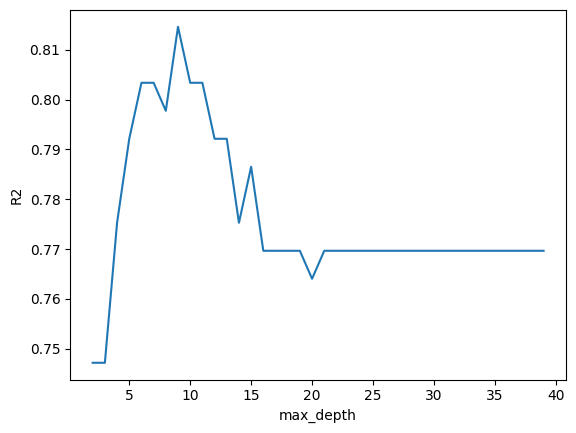

In [47]:
depths = list(range(2, 40))
forest_scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    forest = RandomForestClassifier(max_depth=depth, random_state=42)
    forest.fit(X_train_processed, y_train)
    forest_train_score = forest.score(X_train_processed, y_train)
    forest_test_score = forest.score(X_test_processed, y_test)
    forest_scores.loc[depth, 'Train Score'] = forest_train_score
    forest_scores.loc[depth, 'Test Score'] = forest_test_score
plt.plot(depths, forest_scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');
forest_sorted_scores = forest_scores.sort_values(by='Test Score', ascending=False)
forest_sorted_scores.head()

,Test Score,Train Score
2,0.814607,0.947566
4,0.808989,0.928839
15,0.808989,0.88764
9,0.803371,0.904494
16,0.803371,0.885768


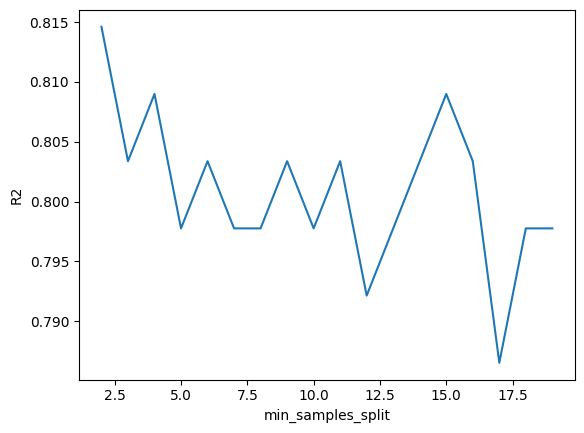

In [48]:
splits = list(range(2, 20))
forest_scores2 = pd.DataFrame(index=splits, columns=['Test Score','Train Score'])
for split in splits:
    forest2 = RandomForestClassifier(min_samples_split=split, max_depth=9, random_state=42)
    forest2.fit(X_train_processed, y_train)
    forest_train_score2 = forest2.score(X_train_processed, y_train)
    forest_test_score2 = forest2.score(X_test_processed, y_test)
    forest_scores2.loc[split, 'Train Score'] = forest_train_score2
    forest_scores2.loc[split, 'Test Score'] = forest_test_score2
plt.plot(splits, forest_scores2['Test Score'])
plt.xlabel('min_samples_split')
plt.ylabel('R2');
forest_sorted_scores2 = forest_scores2.sort_values(by='Test Score', ascending=False)
forest_sorted_scores2.head()

In [49]:
from sklearn.model_selection import GridSearchCV

Training AUC: 0.9997791682002208
Testing AUC: 0.8348037335379107


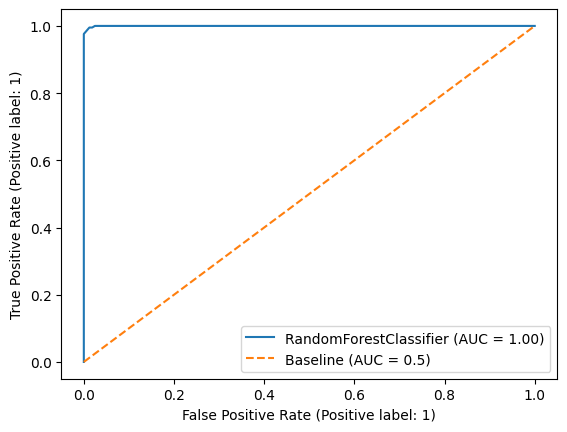

In [50]:
print(f'Training AUC: {roc_auc_score(y_train, rf_clf.predict_proba(X_train_processed)[:,1])}')
print(f'Testing AUC: {roc_auc_score(y_test, rf_clf.predict_proba(X_test_processed)[:,1])}')
RocCurveDisplay.from_estimator(rf_clf, X_train_processed, y_train)
plt.plot([0, 1], [0, 1], ls = '--', label = 'Baseline (AUC = 0.5)')
plt.legend();

#### Metrics RF_CLF

In [51]:
rf_best_pipe = make_pipeline(StandardScaler(), RandomForestClassifier(min_samples_split=2, max_depth=9))
rf_best_pipe.fit(X_train_processed, y_train)
rf_best_pipe.fit(X_train_processed, y_train)
rf_best_pred= rf_best_pipe.predict(X_test_processed)
accuracy6 = accuracy_score(y_test, rf_best_pred)
print(f"RF Training R2: {rf_best_pipe.score(X_train_processed,y_train):.3f}")
print(f"RF Test R2: {rf_best_pipe.score(X_test_processed,y_test):.3f}")
print(f"RF Accuracy: {accuracy6}")
recall6 = recall_score(y_test, rf_best_pred, pos_label=1)
print(f"RF Recall: {recall6}")
precision6 = precision_score(y_test, rf_best_pred, pos_label=1)
print(f"RF Precision: {precision6}")

RF Training R2: 0.946
RF Test R2: 0.792
RF Accuracy: 0.7921348314606742
RF Recall: 0.6962025316455697
RF Precision: 0.8088235294117647


In [52]:
print(f"L1 Train R2: {l1best.score(X_train_processed,y_train):.3f}")
print(f"L1 Test R2: {l1best.score(X_test_processed,y_test):.3f}")
accuracy2 = accuracy_score(y_test, l1best_pred)
print(f"L1 Tree Accuracy: {accuracy2}")
recall2 = recall_score(y_test, l1best_pred, pos_label=1)
print(f"L1 Tree Recall: {recall2}")
precision2 = precision_score(y_test, l1best_pred, pos_label=1)
print(f"L1 Tree Precision: {precision2}")

L1 Train R2: 0.816
L1 Test R2: 0.792
L1 Tree Accuracy: 0.7921348314606742
L1 Tree Recall: 0.7088607594936709
L1 Tree Precision: 0.8


In [53]:
print(f"KNN Training R2: {knn_best_pipe.score(X_train_processed,y_train):.3f}")
print(f"KNN Test R2: {knn_best_pipe.score(X_test_processed,y_test):.3f}")
print(f"KNN Accuracy: {accuracy5}")
recall5 = recall_score(y_test, knn_best_pred, pos_label=1)
print(f"KNN Recall: {recall5}")
precision5 = precision_score(y_test, knn_best_pred, pos_label=1)
print(f"KNN Precision: {precision5}")

KNN Training R2: 0.822
KNN Test R2: 0.787
KNN Accuracy: 0.7752808988764045
KNN Recall: 0.6329113924050633
KNN Precision: 0.819672131147541


Logarithmic regression has slightly better metrics in every category